In [130]:
from copy import deepcopy
import numpy as np
import random
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile, assemble
from qiskit.providers import backend
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt
import itertools

In [131]:
# TYPES:
CAT = "c"
# DOG = "d"
MOUSE = "m"
EMPTY = "emp"

# ACTIONS:
UP = "00"
DOWN = "01"
LEFT = "10"
RIGHT = "11"
ACTIONS = [UP, DOWN, LEFT, RIGHT]

# random seed
#random.seed(10)
#np.random.seed(10)

In [132]:
# state of cat
class State:
    def __init__(self, catP):
        self.row = catP[0]
        self.column = catP[1]
        self.catP = catP

    def __eq__(self, other):
        return isinstance(other, State) and self.row == other.row and self.column == other.column and self.catP == other.catP

    def __hash__(self):
        return hash(str(self.catP))

    def __str__(self):
        return f"State(cat_pos={self.catP})"

In [133]:
# GridWorld
# e.g.
#  MOUSE | EMPTY | EMPTY
#  EMPTY | EMPTY | EMPTY
#  EMPTY | EMPTY | CAT
class GridWorld:
    def __init__(self, s, catP, mouseP):
        self.numRows = s[0]
        self.numColumns = s[1]
        self.catP = catP
        self.mouseP = mouseP
        # self.dogP = dogP
        assert(not self.compaireList(self.catP, self.mouseP))
    
    def getItem(self, p):
        if p[0]>=self.numRows or p[0]<0:
            return None
        if p[1]>=self.numColumns or p[1]<0:
            return None
        if self.compaireList(p, catP):
            return CAT
        elif self.compaireList(p, mouseP):
            return MOUSE
        # elif self.compaireList(p, DOG):
        #     return DOG
        else:
            return EMPTY

    def compaireList(self, l1,l2):
        for i, j in zip(l1, l2):
            if i!=j:
                return False
        return True

    def getNumRows(self):
        return self.numRows

    def getNumColumns(self):
        return self.numColumns

    def getMouse(self):
        return self.mouse
    
    def getCatP(self):
        return self.catP

    def setCatP(self, p):
        self.catP = p
        
    def setMouseP(self, p):
        self.mouseP = p
    
    def initCatState(self, rd = False):
        # init cat position
        if not rd:
            catP = [self.getNumRows() - 1, self.getNumColumns() - 1]
        else:
            catP = [random.randint(0, self.getNumRows()), random.randint(0, self.getNumColumns())]
            while self.getItem(catP) != EMPTY and self.getItem(catP) != CAT:
                catP = [random.randint(0, self.getNumRows()), random.randint(0, self.getNumColumns())]
        self.setCatP(catP)
        return State(catP)
    
    def show(self):
        output = ""
        for i in range(self.numRows):
            for j in range(self.numColumns):
                if self.compaireList([i,j], self.catP):
                    output += CAT + " "
                if self.compaireList([i,j], self.mouseP):
                    output += MOUSE + " "
                if not self.compaireList([i,j], self.catP) and not self.compaireList([i,j], self.mouseP):
                    output += EMPTY + " "
            output += "\n"
        print(output)

In [134]:
# QNet
class QNet:
    
    def __init__(self, qTable, gridWorld:GridWorld, params, alpha=0.1, gamma=1.0, eps=0.4, actions=[UP, DOWN, LEFT, RIGHT]):
        
        self.params = params # inital parameters are the same for all qNetwork
        self.gw = gridWorld
        self.qt = qTable
        self.eps = eps
        self.backend = Aer.get_backend("qasm_simulator")
        self.NUM_SHOTS = 1000 # number of measurements 
        self.optimizer = COBYLA(maxiter=500, tol=0.0001) # off the shelf
        self.gamma = gamma
        self.alpha = alpha
        self.ACTIONS = actions

        # self.rets = {(0,0):([0,..,0],0.0,0), ...}
        self.rets = dict() # resulting parameters after optimization for all points in the grid

        self.state = None
        
        for i in range(self.gw.getNumRows()):
            for j in range(self.gw.getNumColumns()):
                self.rets[i, j] = (self.params, 0.0, 0) 
    
    def qcMaker(self, params):
        qr = QuantumRegister(2, name="q")
        cr = ClassicalRegister(2, name="c")
        qc = QuantumCircuit(qr, cr)
        qc.u3(params[0], params[1], params[2], qr[0])
        qc.u3(params[3], params[4], params[5], qr[1])
        # qc.cx(qr[0], qr[1])
        qc.measure(qr, cr)
        return qc

    def newPosition(self, state, action):
        p = deepcopy(state.catP)
        if action == UP:
            p[0] = max(0, p[0] - 1)
        elif action == DOWN:
            p[0] = min(self.gw.getNumRows() - 1, p[0]+1)
        elif action == LEFT:
            p[1] = max(0, p[1] - 1)
        elif action == RIGHT:
            p[1] = min(self.gw.getNumColumns() - 1, p[1] + 1)
        else:
            raise ValueError(f"Unkown action {action}")
        return p
        
    def getReward(self, p):
        grid = self.gw.getItem(p)
        if grid == EMPTY:
            reward = -1
        # elif grid == DOG:
        #     reward = -1000
        elif grid == MOUSE:
            reward = 100
        elif grid == CAT:
            reward = -1 # (maybe less than reward of empty)
        else:
            raise ValueError(f"Unknown grid item {grid}")
        return reward
    
    def selectAction(self, state, training):
        if random.uniform(0, 1) < self.eps:
            return random.choice(self.ACTIONS)
        else:
            if training:
                self.state = state
                self.updateCircuit(state)
            return self.ACTIONS[np.argmax(self.qt[self.state.catP[0], self.state.catP[1]])]
        
    def lossFunction(self, params):
        qc = self.qcMaker(params=params)
        t_qc = transpile(qc, self.backend)
        job = assemble(t_qc, shots=self.NUM_SHOTS)
        rlt = self.backend.run(job).result()
        counts = rlt.get_counts(qc) 
        action = max(counts, key = counts.get)
        nextPosition = self.newPosition(self.state, action) # handle the 
        reward = self.getReward(nextPosition)
        # update q-table(but not very sure, update only for this action or for all actions)
        targetQvalue = reward + self.gamma *  np.max(self.qt[nextPosition[0],nextPosition[1]])
        predictedQvalue = self.calculateQvalue(action, nextPosition, reward, self.state)
        
        # update q-table
        self.updateQtable(predictedQvalue, action)
        return targetQvalue - self.qt[self.state.catP[0],self.state.catP[1]][int(action,2)]
    
    def updateQtable(self, predictedQvalue, action):
        if self.qt[(self.state.catP[0],self.state.catP[1])][int(action,2)] < predictedQvalue:
            self.qt[self.state.catP[0],self.state.catP[1]][int(action,2)] = predictedQvalue

    def calculateQvalue(self, action, nextPosition, reward, state:State):
        targetQvalue = reward + self.gamma *  np.max(self.qt[nextPosition[0],nextPosition[1]])
        return self.qt[state.catP[0], state.catP[1]][int(action,2)] + self.alpha * (targetQvalue - self.qt[state.catP[0],state.catP[1]][int(action,2)]) # update q-table

    def updateCircuit(self, state:State):
        self.rets[state.catP[0], state.catP[1]] = self.optimizer.optimize(num_vars=6, objective_function=self.lossFunction, initial_point=self.rets[state.catP[0], state.catP[1]][0])

    def setAlpha(self, alpha):
        self.alpha = alpha

    def drawVectors(self, hasdiagonals):
        # Draw vectors representing the cat's desired direction for each place in the grid based on the Qtable
        x = np.linspace(0, self.gw.getNumColumns()-1, self.gw.getNumColumns())
        y = np.linspace(0, self.gw.getNumColumns()-1, self.gw.getNumColumns())
        vecx=np.zeros([len(x),len(y)])
        vecy=np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                vecx[i,j] = self.qt[(x[i], y[j])][3]-self.qt[(x[i], y[j])][2]
                vecy[i,j] = self.qt[(x[i], y[j])][0]-self.qt[(x[i], y[j])][1]
                norm = np.sqrt(vecx[i,j]**2 + vecy[i,j]**2)
                vecx[i,j]=-vecx[i,j]/norm
                vecy[i,j]=-vecy[i,j]/norm
        pts = itertools.product(x, y)
        plt.scatter(*zip(*pts), marker='o', s=30, color='red')
        X, Y = np.meshgrid(x, y)
        QP = plt.quiver(X, Y, vecx, vecy)
        plt.grid()
        plt.show()

In [135]:
# agent: cat
class Cat:
    def __init__(self, qNet: QNet, training=True, eps = 0.2, actions = [UP, DOWN, LEFT, RIGHT]):
        self.eps = eps
        self.training = training
        self.qNet = qNet
        self.ACTIONS = actions
        self.state = None

    def newPosition(self, state, action):
            p = deepcopy(state.catP)
            if action == UP:
                p[0] = max(0, p[0] - 1)
            elif action == DOWN:
                p[0] = min(self.qNet.gw.getNumRows() - 1, p[0] + 1)
            elif action == LEFT:
                p[1] = max(0, p[1] - 1)
            elif action == RIGHT:
                p[1] = min(self.qNet.gw.getNumColumns() - 1, p[1] + 1)
            else:
                raise ValueError(f"Unkown action {self.ACTIONS[action]}")
            return p

    def getReward(self, p):
        grid = self.qNet.gw.getItem(p)
        if grid == MOUSE:
            reward = 1000
            end = True
            self.qNet.gw.setCatP(p)
        # elif grid == DOG:
        #     reward = -100
        #     end = True
        #     self.qNet.gw.setCatP(p)
        elif grid == EMPTY:
            reward = -1
            end = False
            self.qNet.gw.setCatP(p)
        elif grid == CAT:
            reward = -1 # (maybe less than reward of empty)
            end = False
        else:
            raise ValueError(f"Unknown grid item {grid}")
        return reward, end

    def act(self, state, action):
        p = self.newPosition(state, action)
        reward, end = self.getReward(p)
        return p, reward, end
    
    def updateQtable(self, action, p, reward, state):
        pqv = self.qNet.calculateQvalue(action, p, reward, state)
        self.qNet.updateQtable(pqv, action)

    def setTraining(self, training):
        self.Training = training

In [136]:
# The pet school
class PetSchool:
    def __init__(self, cat:Cat, numEpisodes, maxEpisodeSteps, training=True, minAlpha = 0.02, eps = 0.2):
        self.cat = cat
        self.training = training
        self.NUM_EPISODES = numEpisodes
        self.MAX_EPISODE_STEPS = maxEpisodeSteps
        self.alphas = np.linspace(1.0, minAlpha, self.NUM_EPISODES)
        self.eps = eps

    def train(self):
        a=[]
        b=[]
        counter = 0
        for e in range(self.NUM_EPISODES): #  episode: a rund for agent
            print("episode: ", e)
            state = self.cat.qNet.gw.initCatState(rd=True) # default is rd = False
            self.cat.qNet.setAlpha(self.alphas[e])
            total_reward  = 0
            step = 0
            end = False
            for _ in range(self.MAX_EPISODE_STEPS): # step: a time step for agent
                action = self.cat.qNet.selectAction(deepcopy(state), self.training)
                p, reward, end = self.cat.act(state, action)
                # self.cat.updateQtable(action, p, reward, state)
                total_reward += reward
                step += 1
                counter += 1
                if end:
                    print("catch the mouse!!!")
                    print("total reward: ", total_reward, "steps: ", step)
                    break
            a.append(counter)
            b.append(e)
            print("counter: ", counter)
        plt.plot(b,a)

    def show(self):
        self.cat.qNet.gw.show()
        print("qTable: ", self.cat.qNet.qt)
        print("\nparams: ", self.cat.qNet.rets)
        self.cat.qNet.drawVectors(False)

    def initqTable(self, actions, size):
        d = {}
        for i in range(size[0]):
            for j in range(size[1]):
                d[i,j] = np.zeros(len(actions))
        return d
        
    def mouseMove(p,oldPos): # goal (mouse) moves randomly with prob p every time the cat moves
        side = 2 # Number of cells per side of the grid
        if np.random.random() < p:
            n = np.random.random()
            if n < 0.25:
                newPos = (max(0, oldPos[0]-1),oldPos[1])
            elif n < 0.5:
                newPos = (min(side - 1, oldPos[0]+1),oldPos[1])
            elif n < 0.75:
                newPos = (oldPos[0],max(0, oldPos[1]-1))
            else:
                newPos = (oldPos[0],min(side - 1, oldPos[1]+1))
        else:
            newPos = oldPos
        return newPos

In [137]:
# super parameter
gridSize = [3, 3]
catP = [gridSize[0]-1, gridSize[0]-1]
mouseP = [0, 0]
EPS = 20
MAX_EPS_STEP = 30
sizeOfParams = 6
gamma = 0.98

episode:  0


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  30
episode:  1


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  60
episode:  2


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  90
episode:  3


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  120
episode:  4


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  150
episode:  5


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  180
episode:  6


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  210
episode:  7


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  240
episode:  8


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  270
episode:  9


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  300
episode:  10


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  330
episode:  11


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  360
episode:  12


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  390
episode:  13


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  420
episode:  14


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  450
episode:  15


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  480
episode:  16


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  510
episode:  17


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  540
episode:  18


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  570
episode:  19


C:\Users\Usuario\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


counter:  600


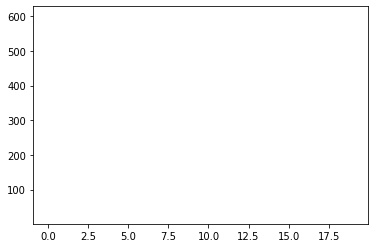

In [138]:
def initqTable(size, actions=[UP, DOWN, LEFT, RIGHT]):
    d = {}
    for i in range(size[0]):
        for j in range(size[1]):
            d[i,j] = np.zeros(len(actions))
    return d

# initGridWorld
gridWorld = GridWorld(gridSize, catP=catP, mouseP=mouseP)
# init parameter
initialParameters = np.zeros(sizeOfParams)
# init q Table
qt = initqTable(gridSize)
# init q Circuit
qNet = QNet(qt, gridWorld, initialParameters, gamma=gamma)
# init cat
cat = Cat(qNet=qNet)
# init pet school
petSchool = PetSchool(cat, EPS, MAX_EPS_STEP)
# start training
petSchool.train()


m emp emp 
emp emp emp 
emp c emp 

qTable:  {(0, 0): array([0., 0., 0., 0.]), (0, 1): array([0., 0., 0., 0.]), (0, 2): array([0., 0., 0., 0.]), (1, 0): array([0., 0., 0., 0.]), (1, 1): array([0., 0., 0., 0.]), (1, 2): array([0., 0., 0., 0.]), (2, 0): array([0., 0., 0., 0.]), (2, 1): array([0., 0., 0., 0.]), (2, 2): array([0., 0., 0., 0.])}

params:  {(0, 0): (array([0., 0., 0., 0., 0., 0.]), 0.0, 0), (0, 1): (array([0., 0., 0., 0., 0., 0.]), 0.0, 0), (0, 2): (array([0., 0., 0., 0., 0., 0.]), -1.0, 37), (1, 0): (array([0., 0., 0., 0., 0., 0.]), 0.0, 0), (1, 1): (array([0., 0., 0., 0., 0., 0.]), -1.0, 37), (1, 2): (array([0., 0., 0., 0., 0., 0.]), -1.0, 37), (2, 0): (array([0., 0., 0., 0., 0., 0.]), -1.0, 37), (2, 1): (array([0., 0., 0., 0., 0., 0.]), -1.0, 37), (2, 2): (array([0., 0., 0., 0., 0., 0.]), -1.0, 37)}


C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\quiver.py:678: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


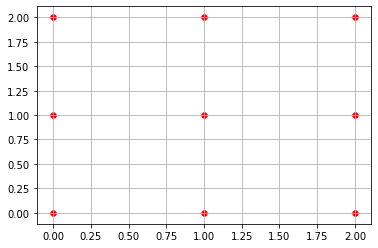

In [139]:
# show what have been learned
petSchool.show()